In [148]:
# Import necessary libraries
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, hamming_loss, f1_score
from sklearn.manifold import TSNE
from intervaltree import Interval, IntervalTree

import time
import matplotlib.pyplot as plt
import sys
import os
import urllib.request
import gzip
import shutil
from Bio import SeqIO
from Bio import Entrez
from Bio.SeqFeature import CompoundLocation

from dotenv import load_dotenv


In [ ]:
def searchNcbiGenome(searchTerm, max):
    """Search NCBI for all bacterial genomes matching the criteria."""
    handle = Entrez.esearch(db="assembly", term=searchTerm, retmax=max)
    record = Entrez.read(handle)
    handle.close()
    
    if record["IdList"]:
        return record["IdList"]  # List of Assembly IDs
    else:
        print("No bacterial genomes found.")
        return []

def getGbffUrl(id):
    """Retrieve the FTP URL for downloading the GBFF file."""
    handle = Entrez.esummary(db="assembly", id=id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    try:
        ftpPath = record["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_RefSeq"]
        if not ftpPath:  # If RefSeq is not available, get GenBank version
            # print(f"Skipping {id} (No RefSeq available, only GenBank).")
            # return None
            ftpPath = record["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_GenBank"]
            if not ftpPath:
                print(f"No FTP path found for assembly {id}")
                return None

        # Construct GBFF file URL
        filename = ftpPath.split("/")[-1] + "_genomic.gbff.gz"
        url = f"{ftpPath}/{filename}"
        return url

    except Exception as e:
        print(f"Error retrieving FTP URL: {e}")
        return None

def downloadGbffFile(url, outFile):
    """Download the GBFF file from the provided FTP URL."""
    try:
        urllib.request.urlretrieve(url, outFile)
        print(f"Downloaded: {outFile}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")

# Load variables from .env file
load_dotenv()

# # Verify they are loaded
# print("NCBI Email:", Entrez.email)
# print("NCBI API Key:", Entrez.api_key)

# Set Entrez API credentials
Entrez.email = os.getenv("NCBI_EMAIL", "your-email@example.com")
Entrez.api_key = os.getenv("NCBI_API_KEY", None)

# Directory to store downloaded GBFF files
outDirectory = "../data/downloads"
os.makedirs(outDirectory, exist_ok=True)

# Search term to retrieve annotated bacterial genomes
searchTerm = '"Bacteria"[Organism] AND "Complete Genome"[AssemblyStatus] AND "latest_refseq"[PropertyList] AND "refseq_has_annotation"[PropertyList]'
maxResults = 100

# Get list of bacterial genome assembly IDs
assemblyIDs = searchNcbiGenome(searchTerm, maxResults)
print(assemblyIDs)


In [ ]:
# Download each bacterial genome
for ID in assemblyIDs:
    URL = getGbffUrl(ID)
    if URL:
        outFile = os.path.join(outDirectory, f"{ID}.gbff.gz")
        downloadGbffFile(URL, outFile)
    
    # Avoid exceeding NCBI rate limits
    time.sleep(1)


In [ ]:
# Extract GBFF contents
def extractFiles(directory):
    """Extract all .gbff.gz files in the directory."""
    for filename in os.listdir(directory):
        if filename.endswith(".gbff.gz"):
            gzPath = os.path.join(directory, filename)
            gbffPath = os.path.join(directory, filename.replace(".gz", ""))

            try:
                # Extract .gbff.gz to .gbff
                with gzip.open(gzPath, "rb") as f_in:
                    with open(gbffPath, "wb") as f_out:
                        shutil.copyfileobj(f_in, f_out)

                print(f"Extracted: {gbffPath}")

                # Delete the .gz file after extraction
                os.remove(gzPath)

            except Exception as e:
                print(f"Failed to extract {gzPath}: {e}")

# Run extraction
extractFiles(outDirectory)


In [16]:
# Process downloaded GBFF files
dataDirectory = "../data/downloads"

valid_gene_types = ["CDS", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
valid_other_types = ["regulatory", "protein_bind", "mobile_element"]

data = []
for i, filename in enumerate(os.listdir(dataDirectory)):
    print(f"processing File {i}: {filename}")
    if filename.endswith(".gbff"):
        fullPath = os.path.join(dataDirectory, filename)
        # Read the file and parse it as a GenBank record
        with open(fullPath, "r") as input:
            for record in SeqIO.parse(input, "genbank"):
                accessionNum = record.id
                genome = record.seq
                genomeLength = len(genome)
                description = record.description
                genomeType = "plasmid" if "plasmid" in description.lower() else "chromo"

                # print(f"Accession: {record.id}")
                # print(f"Genome Length: {genomeLength} bp")
                # print(f"Type of genome: {genomeType}")
                # print(f"Description: {description}")

                # Store all `source` regions
                source_regions = []
                for gene in record.features:
                    if gene.type == "source":
                        source_info = {
                            "organism": gene.qualifiers.get("organism", ["Unknown"])[0],
                            "mol_type": gene.qualifiers.get("mol_type", ["Unknown"])[0],
                            "location": gene.location,  # May be CompoundLocation
                            "strain": gene.qualifiers.get("strain", ["Unknown"])[0],
                            "serovar": gene.qualifiers.get("serovar", ["Unknown"])[0],
                            "sub_species": gene.qualifiers.get("sub_species", ["Unknown"])[0],
                        }
                        source_regions.append(source_info)

                genes = []
                for gene in record.features:
                    organism = None
                    subspecies = None
                    moleculeType = None
                    strain = None
                    serovar = None

                    geneType = gene.type
                    if geneType not in valid_gene_types + valid_other_types:
                        continue  # Skip unwanted feature types
                    geneName = None
                    locusTag = None
                    geneStart = gene.location.start
                    geneEnd = gene.location.end
                    strand = "+" if gene.location.strand == 1 else "-"
                    labelsForGenePresence = genome[geneStart:geneEnd]
                    GCContent = (labelsForGenePresence.count("G") + labelsForGenePresence.count("C")) / len(labelsForGenePresence) if len(labelsForGenePresence) > 0 else 0

                    proteinProduct = None
                    aminoAcidSeq = None
                    regClass = None
                    boundMoiety = None
                    RNAProduct = None
                    ncRNAClass = None
                    elementType = None

                    if geneType == "mobile_element":
                        elementType = gene.qualifiers.get("mobile_element_type", ["Unknown"])[0]
                    elif geneType == "protein_bind":
                        boundMoiety = gene.qualifiers.get("bound_moiety", ["Unknown"])[0]
                    else:
                        geneName = gene.qualifiers.get("gene", ["Unknown"])[0]
                        locusTag = gene.qualifiers.get("locus_tag", ["Unknown"])[0]
                        # Extract protein-coding information
                        if geneType == "CDS":
                            proteinProduct = gene.qualifiers.get("product", ["Unknown"])[0]
                            aminoAcidSeq = gene.qualifiers.get("translation", ["Unknown"])[0]
                        elif geneType == "regulatory":
                            regClass = gene.qualifiers.get("regulatory_class", ["Unknown"])[0]
                        elif geneType == "ncRNA":
                            ncRNAClass = gene.qualifiers.get("ncRNA_class", ["Unknown"])[0]
                        elif geneType != "gene":
                            RNAProduct = gene.qualifiers.get("product", ["Unknown"])[0]
                    
                    # Check which `source` the gene belongs to
                    for source in source_regions:
                        source_location = source["location"]

                        # If `source_location` is compound, check each part
                        if isinstance(source_location, CompoundLocation):
                            for subregion in source_location.parts:
                                if geneStart in subregion:  # Gene is inside a main genome section
                                    organism = source["organism"]
                                    subspecies = source["sub_species"]
                                    moleculeType = source["mol_type"]
                                    strain = source["strain"]
                                    serovar = source["serovar"]
                                    break
                        else:
                            if geneStart in source_location:  # Gene is inside a simple (non-compound) source
                                organism = source["organism"]
                                subspecies = source["sub_species"]
                                moleculeType = source["mol_type"]
                                organism = source["organism"]
                                moleculeType = source["mol_type"]
                                strain = source["strain"]
                                serovar = source["serovar"]
                                break

                    previousGeneEnd = None
                    for prevGene in reversed(genes):  # Search backward
                        if prevGene["Strand"] == strand and prevGene["Organism"] == organism:  # Only consider same-strand genes from same source
                            previousGeneEnd = prevGene["End"]
                            break
                    intergenicDistance = geneStart - previousGeneEnd if previousGeneEnd is not None else None
                    # print(f"Gene: {geneName}, Location: {geneStart}-{geneEnd}, Strand: {strand}")

                    # Store extracted features
                    genes.append({
                        "Organism": organism,
                        "Subspecies": subspecies,
                        "MoleculeType": moleculeType,
                        "Strain": strain,
                        "Serovar": serovar,
                        "GeneType": geneType,
                        "GeneName": geneName,
                        "LocusTag": locusTag,
                        "Start": geneStart,
                        "End": geneEnd,
                        "Strand": strand,
                        "GeneLength": len(labelsForGenePresence),
                        "GCContent": GCContent,
                        "ElementType": elementType,
                        "BoundMoiety": boundMoiety,
                        "ProteinProduct": proteinProduct,
                        "AminoAcidSeq": aminoAcidSeq,
                        "RegulatoryClass": regClass,
                        "ncRNAClass": ncRNAClass,
                        "RNAProduct": RNAProduct,
                        "IntergenicDistance": intergenicDistance,
                    })
                data.append({
                    "Accession": accessionNum,
                    "GenomeLength": genomeLength,
                    "Sequence": genome,
                    "Description": description,
                    "GenomeType": genomeType,
                    "Genes": genes
                })

# Gene types:
# ['source', 'gene', 'CDS', 'regulatory', 'protein_bind', 'rRNA', 'tRNA', 'ncRNA', 'mobile_element', 'tmRNA', 'misc_RNA']
# Qualifiers
# {'organism': ['Salmonella enterica subsp. enterica serovar Typhimurium str. LT2'], 'mol_type': ['genomic DNA'], 'strain': ['LT2'], 'serovar': ['Typhimurium'], 'sub_species': ['enterica'], 'culture_collection': ['ATCC:700720', 'SGSC:1412'], 'type_material': ['type strain of Salmonella enterica'], 'db_xref': ['taxon:99287'], 'focus': ['']}
# {'organism': ['Salmonella enterica subsp. enterica serovar Typhimurium str. LT2'], 'mol_type': ['genomic DNA'], 'strain': ['LT2'], 'serovar': ['Typhimurium'], 'sub_species': ['enterica'], 'culture_collection': ['SGSC:1412'], 'type_material': ['type strain of Salmonella enterica'], 'db_xref': ['taxon:99287'], 'plasmid': ['pSLT']}

# for record in data:
#     for element in record.items():
#         if element[0] != "Genes":
#             print(element)
# for gene in data[1]["Genes"]:
#     print(gene)


processing File 0: Salmonella.gbff
processing File 1: tuberculosis.gbff


In [17]:
print(len(data))


3


In [ ]:

## Skip if using direct download method ##



# Fetch sequence and annotation data remotely
def getAssemblyAccessionID(id):
    """Retrieve the assembly accession ID for a genome assembly."""
    handle = Entrez.esummary(db="assembly", id=id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    try:
            # Extract GenBank nucleotide accession (used in nuccore)
            document = record["DocumentSummarySet"]["DocumentSummary"][0]
            accession = document["AssemblyAccession"]  # Use GenBank ID for nuccore

            if not accession:
                print(f"No nucleotide accession found for assembly {id}")
                return None

            return accession

    except KeyError:
        print(f"Failed to retrieve accession for {id}")
        return None

def getNuccoreAccessionID(accession):
    """Retrieve the nucleotide accession ID for a genome assembly."""
    handle = Entrez.esearch(db="nuccore", term=accession, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    # Extract the first valid nucleotide accession
    if record["IdList"]:
        return record["IdList"][0]
    else:
        print(f"No nucleotide accession found for {accession}")
        return None
    
def fetchGbffData(accession):
    """Fetch GBFF data for a genome assembly accession without downloading a file."""
    handle = Entrez.efetch(db="nuccore", id=accession, rettype="gbwithparts", retmode="text")
    records = list(SeqIO.parse(handle, "genbank"))
    handle.close()
    
    return records  # Returns a list of GenBank records

for ID in assemblyIDs:
    print(f"Processing Assembly ID: {ID}")
    assemblyAccession = getAssemblyAccessionID(ID)
    print(f"Assembly Accession: {assemblyAccession}")
    if not assemblyAccession:
        print("Skipping due to missing assembly accession.")
        continue

    # Avoid exceeding NCBI rate limits
    time.sleep(1)

    nucAccession = getNuccoreAccessionID(assemblyAccession)
    print(f"Nucleotide Accession: {nucAccession}")
    if not nucAccession:
        print("Skipping due to missing nucleotide accession.")
        continue

    # Avoid exceeding NCBI rate limits
    time.sleep(1)

    try:
        gbffData = fetchGbffData(nucAccession)
    except Exception as e:
        print(f"Failed to fetch GBFF data for {nucAccession}: {e}")
        continue
    
    # Avoid exceeding NCBI rate limits
    time.sleep(1)

    # Print summary of first record
    if gbffData:
        print(f"Accession: {gbffData[0].id}")
        print(f"Description: {gbffData[0].description}")
        print(f"Sequence Length: {len(gbffData[0].seq)} bp")
        
        # Print first few genes
        for gene in gbffData[0].features[:5]:  
            print(f"Feature Type: {gene.type}, Location: {gene.location}")


In [18]:
essentialGenomeElements = [
    "Sequence", "GenomeType", "Genes",
]
essentialGeneElements = [
    "GeneType", "LocusTag", "Start", "End", "GeneLength", "Strand", 
    "IntergenicDistance", "GCContent", "Organism", "RegulatoryClass", 
    "BoundMoiety", "Serovar", "Strain", "Subspecies"
]
OptionalGeneElements = ["GeneName"]


In [19]:
# Check GPU availability
print(torch.__config__.show())
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")


PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930157
  - Intel(R) oneAPI Math Kernel Library Version 2025.0.1-Product Build 20241031 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 90.1
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, COMMIT_SHA=2236df1770800ffea5697b11b0bb0d910b2e59e1, CUDA_VERSION=11.8, CUDNN_VERSION=9.1.0, CXX_COMPILER=C:/actions-runner/_work/pytorch/

In [20]:
# Initialize DNABert
import torch
from transformers import BertTokenizer, BertModel

# Load the DNABert tokenizer and model (pretrained 6-mer model)
tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)
model = BertModel.from_pretrained("zhihan1996/DNA_bert_6")

# config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
# model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)

if device == "cuda":
    model = model.to(device)


In [21]:
numSequences = 3
dataSubset = []

import random
if numSequences <= len(data):
    for i in range(numSequences):
        randIdx = random.randint(0, len(data) - 1)
        while data[randIdx] in dataSubset:
            randIdx = random.randint(0, len(data) - 1)

        if len(data[randIdx]["Sequence"]) > 100000:
            print(f"Truncated sequence {randIdx}")
            data[randIdx]["Sequence"] = data[randIdx]["Sequence"][0:99999]
            for gene in data[randIdx]["Genes"]:
                if gene["Start"] > 100000  or gene["End"] > 100000:
                    data[randIdx]["Genes"].remove(gene)
        dataSubset.append(data[randIdx])
        print(f"{randIdx}: {len(dataSubset[i]["Sequence"])}")


Truncated sequence 0
0: 99999
1: 93933
Truncated sequence 2
2: 99999


In [22]:
for sequence in dataSubset:
    for i, gene in enumerate(sequence["Genes"]):
        if gene["GeneType"] != "gene" and gene["GeneType"] != "CDS":
            print(f"{i}: {gene["GeneType"]}")


1: regulatory
3: regulatory
5: regulatory
8: regulatory
10: regulatory
11: regulatory
13: regulatory
16: regulatory
18: regulatory
20: regulatory
21: regulatory
23: regulatory
25: regulatory
27: regulatory
30: regulatory
32: regulatory
33: regulatory
35: regulatory
38: regulatory
40: regulatory
43: regulatory
45: regulatory
47: regulatory
49: regulatory
51: regulatory
54: regulatory
55: regulatory
58: regulatory
62: regulatory
63: regulatory
65: regulatory
67: regulatory
69: regulatory
71: regulatory
72: regulatory
73: regulatory
75: regulatory
78: regulatory
80: regulatory
82: regulatory
85: regulatory
88: regulatory
90: regulatory
92: regulatory
94: regulatory
97: regulatory
100: regulatory
102: regulatory
104: regulatory
106: regulatory
108: regulatory
110: regulatory
112: regulatory
114: regulatory
116: regulatory
118: regulatory
121: protein_bind
122: regulatory
123: protein_bind
124: regulatory
125: protein_bind
126: regulatory
128: regulatory
130: protein_bind
131: protein_bind


In [23]:
def extractGeneLocations(record):
    """Extracts start and end positions of all genes in a GBFF record."""
    geneRanges = []
    for gene in record["Genes"]:
        start = int(gene["Start"])
        end = int(gene["End"])
        type = gene["GeneType"]
        geneRanges.append((start, end, type))
    return geneRanges

def buildTreeForGenePresence(geneRanges):
    """
    Builds an interval tree that stores gene presence for fast gene lookup.
    
    geneRanges: List of tuples in the form (start, end, geneType)
    """
    tree = IntervalTree()
    for start, end, geneType in geneRanges:
        tree[start:end] = 1  # Store a value (1) to mark gene presence
    return tree

def buildTreeForGeneType(geneRanges):
    """
    Builds an interval tree that stores gene type info per interval.
    """
    tree = IntervalTree()
    
    for start, end, geneType in geneRanges:
        overlapping = tree[start:end]

        if overlapping:
            # Remove old and replace with merged intervals
            tree.chop(start, end)  # Cut out overlapping region
            tree[start:end] = {geneType}
            for interval in overlapping:
                overlap_start = max(start, interval.begin)
                overlap_end = min(end, interval.end)
                combined_data = set(interval.data) | {geneType}
                tree[overlap_start:overlap_end] = combined_data
        else:
            tree[start:end] = {geneType}

    return tree

def chunk_raw_sequence(sequence, window_size=512, stride=256):
    return [sequence[i:i+window_size] for i in range(0, len(sequence) - window_size + 1, stride)]

def label_raw_sequence_chunk(start_offset, num_kmers, k=6, tree_presence=None, tree_type=None):
    """
    Given a window of a sequence and its start offset in the original sequence,
    return gene presence and gene type labels for each k-mer in the window.
    """
    presence_labels = []
    type_labels = []

    for i in range(num_kmers):
        kmer_start = start_offset + i
        kmer_end = kmer_start + k

        # Gene Presence
        present = 1 if tree_presence[kmer_start] else 0
        presence_labels.append(present)

        # Gene Type
        gene_types = set()
        for interval in tree_type[kmer_start:kmer_end]:
            gene_types.update(interval.data)
        type_labels.append(gene_types)

    return presence_labels, type_labels

kmersList = []
embeddingsListForGenePresence = []
embeddingsListForGeneType = []
labelsListForGenePresence = []
labelsListForGeneType = []

k = 6
num_kmers = 512
window_size = num_kmers * k # Gives 512 6-mers
stride = 256

for i, input in enumerate(dataSubset):
    print(f"Sequence {i + 1}:")
    sequence = str(input["Sequence"])
    # print(len(sequence))
    geneRanges = extractGeneLocations(input)
    # print(len(geneRanges))
    intervalTreeForGenePresence = buildTreeForGenePresence(geneRanges)
    intervalTreeForGeneType = buildTreeForGeneType(geneRanges)
    embeddingsChunkForGenePresence = []
    embeddingsChunkForGeneType = []
    windows = chunk_raw_sequence(sequence, window_size, stride)

    for j, window in enumerate(windows):
        # Convert k-mer list back to space-separated string to avoid dimensional issues
        kmers = [window[i:i+k] for i in range(512)]
        kmer_string = " ".join(kmers)

        # Tokenize input
        inputs = tokenizer(kmer_string, return_tensors='pt', padding=True, truncation=True)
        # print(inputs.shape)
        
        # Embed
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states = outputs[0] # [1, sequence_length, 768]
        hidden_states = hidden_states.squeeze(0)
        
        # Embedding with mean pooling
        print(f"Sequence {i + 1} - Chunk {j + 1} out of {len(windows)} embedding shape: {hidden_states.shape}") # expect to be 768

        # Generate labels for this window
        start_bp = j * stride
        # Label per-k-mer based on interval tree and raw sequence position
        presence_labels, type_labels = label_raw_sequence_chunk(
            start_offset=start_bp,
            num_kmers=num_kmers,
            k=k,
            tree_presence=intervalTreeForGenePresence,
            tree_type=intervalTreeForGeneType
        )
        # print(len(presence_labels), len(type_labels))
        
        embeddingsChunkForGenePresence.append((hidden_states, presence_labels))
        embeddingsChunkForGeneType.append((hidden_states, type_labels))
    embeddingsListForGenePresence.append(embeddingsChunkForGenePresence)
    embeddingsListForGeneType.append(embeddingsChunkForGeneType)
    print("Finished!")


Sequence 1:
Sequence 1 - Chunk 1 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 2 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 3 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 4 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 5 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 6 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 7 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 8 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 9 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 10 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 11 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 12 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 13 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 14 out of 379 embedding shape

In [25]:
print("Presence:")
print("Presence Embeddings: ", type(embeddingsListForGenePresence))
for sequence in embeddingsListForGenePresence:
    print("Sequence embeddings: ", type(sequence))
    for embeds in sequence:
        print("Chunk: ", type(embeds))
        print("Embeddings of chunk: ", type(embeds[0]), embeds[0].shape)
        print("Labels of chunk: ", type(embeds[1]), "Length: ", len(embeds[1]))
        print("Elements in labels list: ", type(embeds[1][0]))
    for kmers in kmersList:
        print(len(kmers[0]))
    for labelsForGenePresence in labelsListForGenePresence:
        print(len(labelsForGenePresence[0]))

print()

print("Type:")
print("Type Embeddings: ", type(embeddingsListForGeneType))
for sequence in embeddingsListForGeneType:
    print("Sequence embeddings: ", type(sequence))
    for embeds in sequence:
        print("Chunk: ", type(embeds))
        print("Embeddings of chunk: ", type(embeds[0]), embeds[0].shape)
        print("Labels of chunk: ", type(embeds[1]), "Length: ", len(embeds[1]))
        print("Elements in labels list: ", type(embeds[1][0]))
    for kmers in kmersList:
        print(len(kmers[0]))
    for labels in labelsListForGeneType:
        print(len(labels[0]))


Presence:
Presence Embeddings:  <class 'list'>
Sequence embeddings:  <class 'list'>
Chunk:  <class 'tuple'>
Embeddings of chunk:  <class 'torch.Tensor'> torch.Size([512, 768])
Labels of chunk:  <class 'list'> Length:  512
Elements in labels list:  <class 'int'>
Chunk:  <class 'tuple'>
Embeddings of chunk:  <class 'torch.Tensor'> torch.Size([512, 768])
Labels of chunk:  <class 'list'> Length:  512
Elements in labels list:  <class 'int'>
Chunk:  <class 'tuple'>
Embeddings of chunk:  <class 'torch.Tensor'> torch.Size([512, 768])
Labels of chunk:  <class 'list'> Length:  512
Elements in labels list:  <class 'int'>
Chunk:  <class 'tuple'>
Embeddings of chunk:  <class 'torch.Tensor'> torch.Size([512, 768])
Labels of chunk:  <class 'list'> Length:  512
Elements in labels list:  <class 'int'>
Chunk:  <class 'tuple'>
Embeddings of chunk:  <class 'torch.Tensor'> torch.Size([512, 768])
Labels of chunk:  <class 'list'> Length:  512
Elements in labels list:  <class 'int'>
Chunk:  <class 'tuple'>
Em

C:\Users\musti\AppData\Local\Temp\ipykernel_29676\1713343937.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")


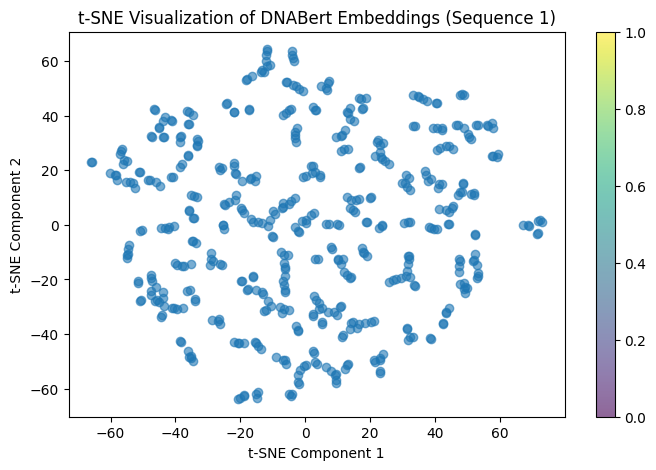

C:\Users\musti\AppData\Local\Temp\ipykernel_29676\1713343937.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")


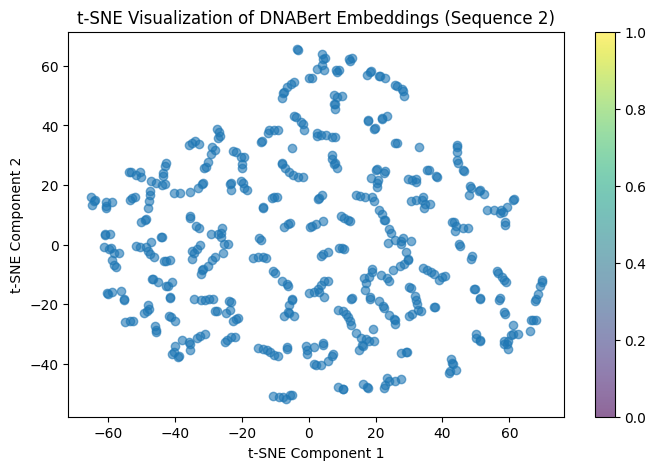

C:\Users\musti\AppData\Local\Temp\ipykernel_29676\1713343937.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")


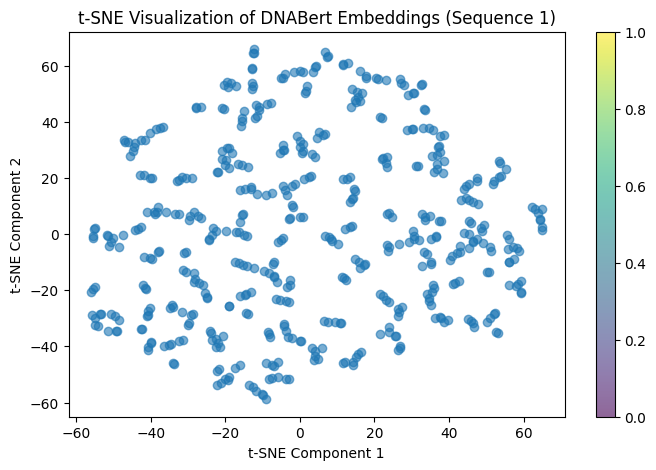

C:\Users\musti\AppData\Local\Temp\ipykernel_29676\1713343937.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")


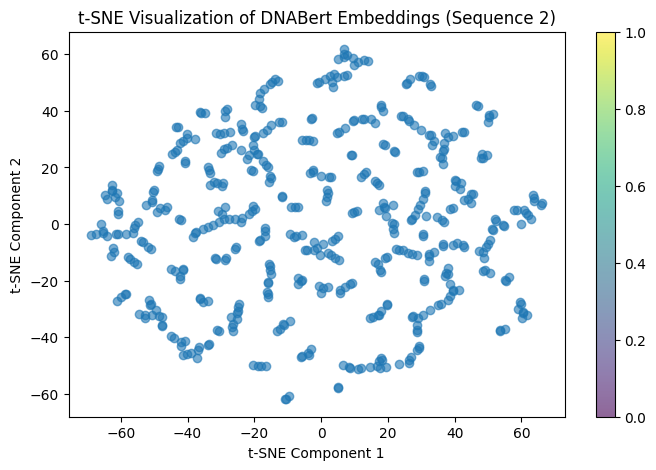

C:\Users\musti\AppData\Local\Temp\ipykernel_29676\1713343937.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")


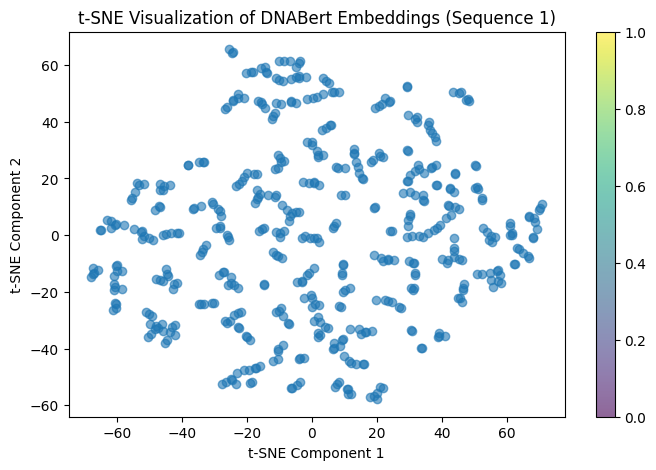

C:\Users\musti\AppData\Local\Temp\ipykernel_29676\1713343937.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")


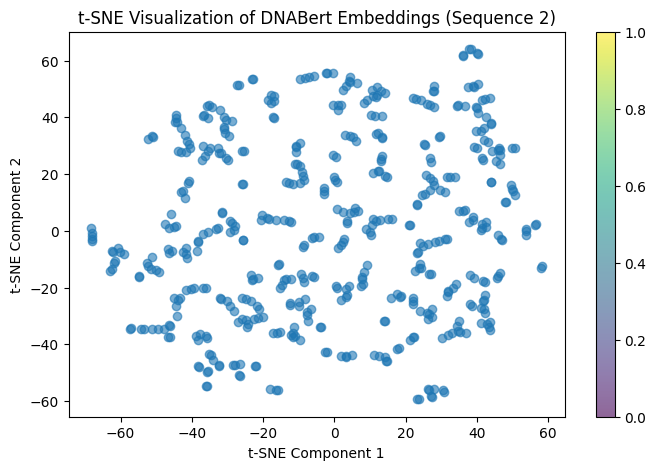

In [26]:
# Plot first 2 embeddings for pattern visualization - Clusters show patterns recognized by DNABert
for sequence in embeddingsListForGenePresence:
    for i, (embeds, labels) in enumerate(sequence):
        # Convert list to numpy array for t-SNE
        embeddingsNpArray = np.vstack(embeds)

        # Reduce to 2D using t-SNE
        tsne = TSNE(n_components=2, perplexity=5, random_state=42)
        # embeddings2d = tsne.fit_transform(embeddingsNpArray)
        embeddings_2d = tsne.fit_transform(embeddingsNpArray)
        # Plot
        plt.figure(figsize=(8, 5))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, cmap="viridis")
        plt.title(f"t-SNE Visualization of DNABert Embeddings (Sequence {i+1})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.colorbar()
        plt.show()

        if i == 1:
            break


In [27]:
# Presence labels structure:            Type labels structure:
# [                                     [
#   [                                       [
#       (                                       (
#           [512,768]                               [512,768]
#        ,                                       ,
#           [1, 0, 1, ...]                          [set("CDS"), set("CDS", "tRNA"), set(), ...]
#       ),                                      ),
#   ],                                      ],
# ]                                     ]
#       
from collections import Counter
for j, sequence in enumerate(embeddingsListForGenePresence):
    total1s = 0
    total0s = 0
    for i, (embeds, labels) in enumerate(sequence):
        Zcount = 0
        Ocount = 0
        for label in labels:
            if label == 0:
                Zcount += 1
                total0s += 1
            if label == 1:
                Ocount += 1
                total1s += 1
        print(f"Chunk {i + 1}: 0s: {Zcount}, 1s: {Ocount}, Total: {Zcount + Ocount}")
    print(f"Sequence {j + 1}: 0s: {total0s}, 1s: {total1s}, Total: {total0s + total1s}")

# valid_gene_types = ["CDS", "gene", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
# valid_other_types = ["regulatory", "protein_bind", "mobile_element"]
allTypes = valid_gene_types + valid_other_types
for s, sequence in enumerate(embeddingsListForGeneType):
    typeCounter = Counter()
    for embeds, labels in sequence:
        for labelSet in labels:
            for geneType in labelSet:
                if geneType in allTypes:
                    typeCounter[geneType] += 1
    total = sum(typeCounter.values())
    print(f"Sequence {s + 1}:")
    for geneType in allTypes:
        print(f"  {geneType}: {typeCounter[geneType]}")
    print(f"  Total labeled kmers: {total}\n")


Chunk 1: 0s: 264, 1s: 248, Total: 512
Chunk 2: 0s: 74, 1s: 438, Total: 512
Chunk 3: 0s: 0, 1s: 512, Total: 512
Chunk 4: 0s: 0, 1s: 512, Total: 512
Chunk 5: 0s: 0, 1s: 512, Total: 512
Chunk 6: 0s: 0, 1s: 512, Total: 512
Chunk 7: 0s: 0, 1s: 512, Total: 512
Chunk 8: 0s: 0, 1s: 512, Total: 512
Chunk 9: 0s: 0, 1s: 512, Total: 512
Chunk 10: 0s: 1, 1s: 511, Total: 512
Chunk 11: 0s: 1, 1s: 511, Total: 512
Chunk 12: 0s: 0, 1s: 512, Total: 512
Chunk 13: 0s: 0, 1s: 512, Total: 512
Chunk 14: 0s: 3, 1s: 509, Total: 512
Chunk 15: 0s: 3, 1s: 509, Total: 512
Chunk 16: 0s: 0, 1s: 512, Total: 512
Chunk 17: 0s: 0, 1s: 512, Total: 512
Chunk 18: 0s: 0, 1s: 512, Total: 512
Chunk 19: 0s: 93, 1s: 419, Total: 512
Chunk 20: 0s: 93, 1s: 419, Total: 512
Chunk 21: 0s: 0, 1s: 512, Total: 512
Chunk 22: 0s: 1, 1s: 511, Total: 512
Chunk 23: 0s: 72, 1s: 440, Total: 512
Chunk 24: 0s: 71, 1s: 441, Total: 512
Chunk 25: 0s: 0, 1s: 512, Total: 512
Chunk 26: 0s: 0, 1s: 512, Total: 512
Chunk 27: 0s: 0, 1s: 512, Total: 512
Chu

Actual Gene Presence: Counter({1: 488251, 0: 81605})
Gene Presence Prediction Accuracy: 0.8741
F1 Score: 0.9314818530088944
              precision    recall  f1-score   support

           0       0.93      0.13      0.23     16321
           1       0.87      1.00      0.93     97651

    accuracy                           0.87    113972
   macro avg       0.90      0.56      0.58    113972
weighted avg       0.88      0.87      0.83    113972



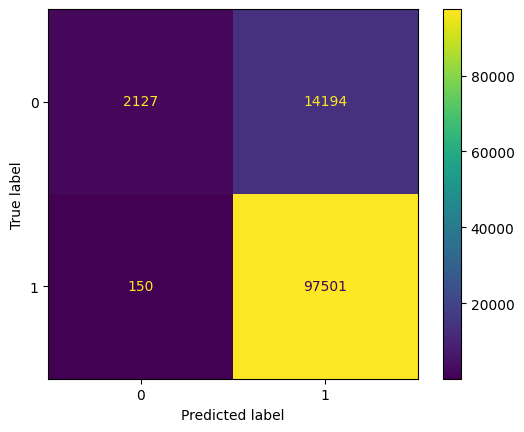

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
X_gene_presence = []  # features
y_gene_presence = []  # labels

for sequence in embeddingsListForGenePresence:
    for embedChunk, labelChunk in sequence:
        for embed, label in zip(embedChunk, map(int, labelChunk)):
            X_gene_presence.append(embed) # Embedding vectors for every k-mer
            y_gene_presence.append(label) # Labels for every k-mer

# Split and train
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_gene_presence, y_gene_presence, stratify=y_gene_presence, test_size=0.2, random_state=42)

genePresenceClassifier = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
genePresenceClassifier.fit(X_train_bin, y_train_bin)

# Evaluate
y_pred_bin = genePresenceClassifier.predict(X_test_bin)
accuracy_gene_presence = accuracy_score(y_test_bin, y_pred_bin)
print(f"Actual Gene Presence: {Counter(y_gene_presence)}")
print(f"Gene Presence Prediction Accuracy: {accuracy_gene_presence:.4f}")
print("F1 Score:", f1_score(y_test_bin, y_pred_bin))
print(classification_report(y_test_bin, y_pred_bin, zero_division=0))
cm = confusion_matrix(y_test_bin, y_pred_bin)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

X_gene_type = []  # features
y_gene_type = []  # labels
allLabels = []
for sequence in embeddingsListForGeneType:
    for embedChunk, labelChunk in sequence:
        for embed, label in zip(embedChunk, labelChunk):
            X_gene_type.append(embed) # Embedding vectors for every k-mer
            if label == set():
                allLabels.append([])
            else:
                allLabels.append(list(label))
            
# Binarize labels for y
multiHotBinarizer = MultiLabelBinarizer(classes=allTypes)  # Fix the class order
multiHotLabels = multiHotBinarizer.fit_transform(allLabels)  # Shape: (n_kmers, n_types)

# Step 1: Get label frequency for each class (column)
label_counts = np.sum(multiHotLabels, axis=0)
# Step 2: Identify columns with at least one positive label
nonzero_indices = np.where(label_counts > 0)[0]
# Step 3: Filter the multi-hot labels
multiHotLabels = multiHotLabels[:, nonzero_indices]
# Step 4: Filter the class labels to match
multiHotBinarizer.classes_ = multiHotBinarizer.classes_[nonzero_indices]

y_gene_type = multiHotLabels


trained
Actual Gene Types:
  CDS: 488459
  tRNA: 490
  misc_RNA: 346
  regulatory: 1808
  protein_bind: 400
Hamming Loss: 0.026292422700312356
Micro F1 Score: 0.9288005436306352
Macro F1 Score: 0.18630014249834387
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     97787
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00       367
           4       0.00      0.00      0.00        72

   micro avg       0.87      0.99      0.93     98397
   macro avg       0.17      0.20      0.19     98397
weighted avg       0.87      0.99      0.93     98397
 samples avg       0.86      0.86      0.86     98397



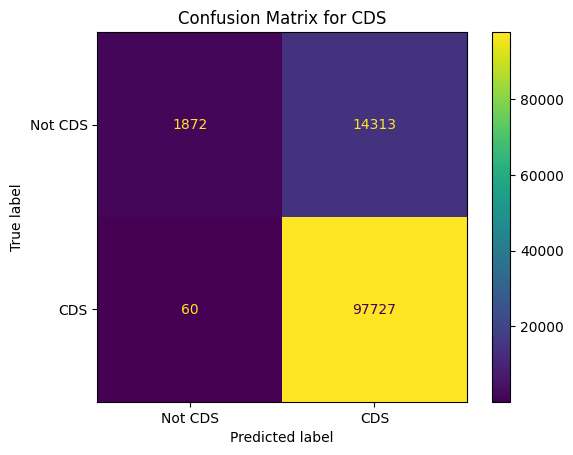

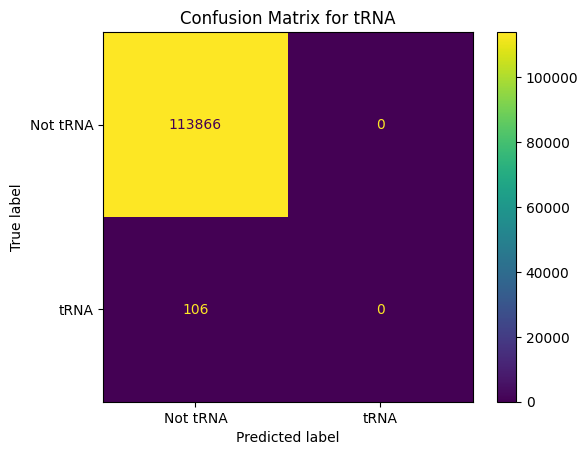

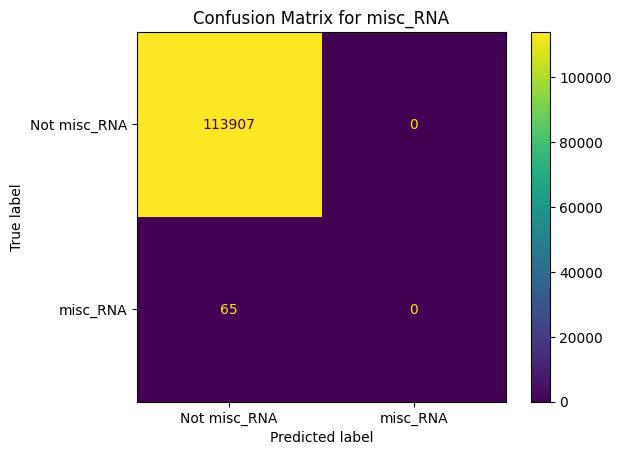

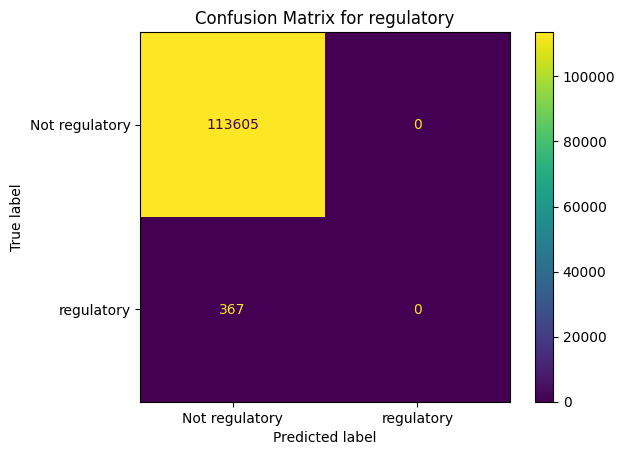

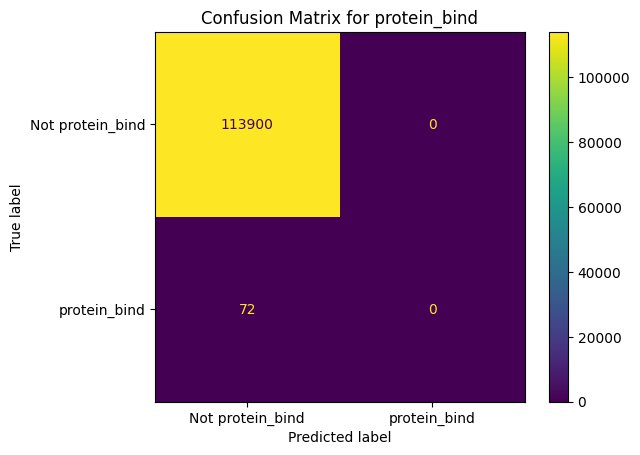

In [32]:
# Split and train
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_gene_type, y_gene_type, test_size=0.2, random_state=42)

# Train classifier on gene types
geneTypeClassifier = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
geneTypeClassifier.fit(X_train_multi, y_train_multi)
print("trained")
# Evaluate
y_pred_multi = geneTypeClassifier.predict(X_test_multi)

# Sum columns to count how many times each gene type appears
gene_type_counts = np.sum(y_gene_type, axis=0)

# Print nicely
print("Actual Gene Types:")
for gene_type, count in zip(multiHotBinarizer.classes_, gene_type_counts):
    print(f"  {gene_type}: {int(count)}")

print("Hamming Loss:", hamming_loss(y_test_multi, y_pred_multi))
print("Micro F1 Score:", f1_score(y_test_multi, y_pred_multi, average='micro'))
print("Macro F1 Score:", f1_score(y_test_multi, y_pred_multi, average='macro'))
print(classification_report(y_test_multi, y_pred_multi, zero_division=0))
for i, gene_type in enumerate(multiHotBinarizer.classes_):
    cm = confusion_matrix(y_test_multi[:, i], y_pred_multi[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {gene_type}", gene_type])
    disp.plot()
    plt.title(f"Confusion Matrix for {gene_type}")
    plt.show()


In [ ]:
# Fine-tuning
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./dnabert-finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Your dataset here
    eval_dataset=eval_dataset
)

# Train DNABert
trainer.train()
